In [ ]:
#!pip install -I scipy==1.2.*

In [ ]:
"""
Team Members:
1. Sabbarish Ramana Rajan
2. Siranjiv Ramana Rajan
3. Gautham Ramajayam
"""

"""
This code is for our third goal mentioned in our proposal: COVID Chest X-Ray Classification using Deep Learning.
In this code we have made use of TensorFlow and concepts related to Convolutional Neural Networks and Deep Learning.
We approached this as a 3 Class classification problem. We have taken Chest X-Rays of COVID infected, Pneumonia infected and of healthy patients.
We built a custom model by using VGG16 as a backbone model and added more layers for this specific task. So a transfer learning appraach was taken were
pre-trained VGG16 ImageNet Weights were used and the added layers were trained to obtain predictions. Initially Data Augmentation was also done. 
Final part of the code is where have plotted our results for training and validation along with predictions for images in test data.

We got these values just before submitting. I have ran the notebook again before sharing and there are slightly different results below.
"""

#Inorder to train the models using GPU, this code was run on Colab Notebooks.

"""
References:
https://github.com/ieee8023/covid-chestxray-dataset
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
https://github.com/anjanatiha/Pneumonia-Detection-from-Chest-X-Ray-Images-with-Deep-Learning
https://towardsdatascience.com/detecting-covid-19-induced-pneumonia-from-chest-x-rays-with-transfer-learning-an-implementation-311484e6afc1
https://www.kaggle.com/rodrigonca/advanced-predictive-analysis-cnn-implementation
https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution
https://www.kaggle.com/sanwal092/intro-to-cnn-using-keras-to-predict-pneumonia
"""


import numpy as np 

import cv2
from imutils import paths
import matplotlib.pyplot as plt

from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 as backbone_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D

import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#!cd '/content/gdrive/My Drive/BigData/'
#!unzip COVID_Data.zip

In [ ]:
cd ./gdrive/My\ Drive/BigData/


/content/gdrive/My Drive/BigData


In [ ]:
#Certain global variables are defined here which are used throughout the code.

img_dims = (150, 150) #Dimensions of images
batch_size = 10 # Batch Size
lr_rate = 0.00003 #Learning Rate
train_data, test_data  = 'COVID_Classes/train', 'COVID_Classes/test' #path to train and test folders
num_epochs = 100 #Number of epochs

In [ ]:

#This function is used for data generation and augmentation using methods in Keras and TensorFlow.
#Different types of augmentation was used as shown below. Vertical flips were avoided as it did not make sense for
#X-Ray images. These outputs were finally passed to train_model function for training the model. 
def data_augmentation(train = True):  

    img_augment_gen = ImageDataGenerator(rescale=1./255, rotation_range = 30, horizontal_flip = True, height_shift_range = 0.2,
                                       width_shift_range = 0.2, zoom_range = 0.1, zca_whitening = True, channel_shift_range = 10,
                                       validation_split = 0.25, fill_mode='constant') #Validation Split is used here to create a split from train data for validation purposes,                                                                   
                                       
    if train == False:
        split_batch = img_augment_gen.flow_from_directory(train_data, target_size = img_dims, batch_size = batch_size,                                                  
                                                  seed = 11, subset = "validation", shuffle = True, class_mode = "categorical") #Data has been shuffled     
    
    else:
        split_batch = img_augment_gen.flow_from_directory(train_data, target_size = img_dims, batch_size = batch_size,
                                                          seed = 11, subset = "training", shuffle = True, class_mode = "categorical")
    
    return split_batch


In [ ]:
#This function is used to builda custom model using VGG16 as a backbone and adding new layers
def build_model(learning_rate = lr_rate):
    
    base_model = backbone_model(input_shape =  (150, 150, 3), include_top = False, weights = 'imagenet')
    base_model.trainable = False #Here we are using weights of VGG16 ImageNet 
    model = models.Sequential()
    
    backbone_feats = Input(base_model.get_output_shape_at(0)[1:], name = 'feature_input')
    backbone_output_shape = base_model.get_output_shape_at(0)[-1]
    batch_norm_feats = BatchNormalization()(backbone_feats) #Batch normalizing the outputs of backbone model as it helps with converging and acts like a regulatizer
    
    #These are the new layers that were added to the custom model. It consists of 2D Convolution layers and Pooling layers
    #Different activation functions were used and experimented with and finally we got slightly better results with relu and sigmoid
    #We have used Average Pooling layers in the model as they seemed to give slightly better results than max pooling layers.
    append_conv1 = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'relu')(batch_norm_feats)
    append_conv2 = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'relu')(append_conv1)
    append_conv3 = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(append_conv2)
    append_conv4 = AvgPool2D((2,2), strides = (1,1), padding = 'same')(append_conv3) 
    append_conv5 = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(append_conv4)
    
    #We have used 1x1 convoltions to keep number of feature maps in range and finally merge with a skip connection like branch below.
    #A skip connection like branch is created from the backbone outputs here and are finally merged with the previous conv layers outputs followed by pooling.
    backbone_output_feats = np.ones((1, 1, 1, backbone_output_shape))
    backbone_output = Conv2D(backbone_output_shape, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [backbone_output_feats])
    backbone_output.trainable = False
    append_conv6 = backbone_output(append_conv5)
    mask_feats = multiply([append_conv6, batch_norm_feats])
    global_average_pool_feats = GlobalAveragePooling2D()(mask_feats)
    global_average_pool_mask = GlobalAveragePooling2D()(append_conv6)
    
    global_average_pool_rescale = Lambda(lambda z: z[0]/z[1], name = 'RescaleGAP')([global_average_pool_feats, global_average_pool_mask])
    global_average_pool_dropout = Dropout(0.5)(global_average_pool_rescale)
    dropout_vals = Dropout(0.5)(Dense(128, activation = 'relu')(global_average_pool_dropout)) #We have used dropout layer as regularization to deal with overfitting
    output_feats = Dense(3, activation = 'softmax')(dropout_vals) #Finally softmax layer for classes is used here
    appended_model = Model(inputs = [backbone_feats], outputs = [output_feats], name = 'appended_model')
    appended_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc']) #We have used Adam optimizer here as it's used in general as a starting optimizer 
    
    print('Appended Model: ')
    print(appended_model.summary()) #The added layers are printed here
    
    final_model = Sequential(name = 'final_model')
    final_model.add(base_model) 
    final_model.add(appended_model) #Backbone and new layer are combined here
    final_model.compile(optimizer = Adam(lr = 1e-3), loss = 'categorical_crossentropy', metrics = ['acc'])
    
    print("Final Model = Backbone + Appended Model: ")
    print(final_model.summary()) #Complete custom model used
    
    return final_model


In [ ]:
build_model()

Appended Model: 
Model: "appended_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      [(None, 4, 4, 512)]  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 4, 4, 512)    2048        feature_input[0][0]              
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 4, 4, 128)    65664       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 4, 4, 32)     4128        conv2d_5[0][0]                   
____________________________________________________________________

In [ ]:
"""
Print output of appended layers

Appended Model: 
Model: "appended_model"

Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
feature_input (InputLayer)      [(None, 4, 4, 512)]  0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 4, 4, 512)    2048        feature_input[0][0]              
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 4, 4, 128)    65664       batch_normalization_2[0][0]      
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 4, 4, 32)     4128        conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 4, 4, 16)     528         conv2d_11[0][0]                  
__________________________________________________________________________________________________
average_pooling2d_2 (AveragePoo (None, 4, 4, 16)     0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 4, 4, 1)      17          average_pooling2d_2[0][0]        
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 4, 4, 512)    512         conv2d_13[0][0]                  
__________________________________________________________________________________________________
multiply_2 (Multiply)           (None, 4, 4, 512)    0           conv2d_14[0][0]                  
                                                                 batch_normalization_2[0][0]      
__________________________________________________________________________________________________
global_average_pooling2d_4 (Glo (None, 512)          0           multiply_2[0][0]                 
__________________________________________________________________________________________________
global_average_pooling2d_5 (Glo (None, 512)          0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
RescaleGAP (Lambda)             (None, 512)          0           global_average_pooling2d_4[0][0] 
                                                                 global_average_pooling2d_5[0][0] 
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 512)          0           RescaleGAP[0][0]                 
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          65664       dropout_4[0][0]                  
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 128)          0           dense_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 3)            387         dropout_5[0][0]                  
==================================================================================================

Print output of Final model

Final Model = Backbone + Appended Model: 
Model: "final_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
appended_model (Model)       (None, 3)                 138948    
=================================================================
"""

In [ ]:
#This function is used for saving the best model weights and checking when to decrease learning rate if there hasn't been much improvement in the validation loss
def model_save_degrade():
    
    feats_checkpoint = "{}_best_feats.hdf5".format('covid_xray_best')
    checkpoint = ModelCheckpoint(feats_checkpoint, monitor = 'val_loss', save_best_only = True, save_weights_only = True, mode = 'min' )
    lr_degrade = ReduceLROnPlateau(monitor='val_loss', patience = 10, factor = 0.8, min_delta = 0.0001, cooldown = 7, mode = 'auto',  min_lr = 0.0001)
    
    return [checkpoint, lr_degrade]


In [ ]:
#This function is used for training the model using train and validation data
def train_model(model, train_data_batch, valid_data_batch, save_degrade_vals, num_epochs = 100):
    
    imgs_per_train_batch = train_data_batch.n // train_data_batch.batch_size 
    imgs_per_val_batch = valid_data_batch.n // valid_data_batch.batch_size 
    train_preds = model.fit_generator(train_data_batch, validation_data = valid_data_batch, steps_per_epoch = imgs_per_train_batch,
                      validation_steps = imgs_per_val_batch, epochs = num_epochs, callbacks = save_degrade_vals, workers = 3) #Model fitting on train/val data takes place here 
    
    return train_preds


In [ ]:
#This function has been used to plot the training and validation metrics provided by the training process of the model.
def train_val_graphs(preds, epochs = 100):

    training_loss, training_acc = preds.history['loss'], preds.history['acc']
    validation_loss, validation_acc = preds.history['val_loss'], preds.history['val_acc']
    x_axis = range(1, epochs)
    
    plt.figure(figsize=(12, 4))
    #Plot for Loss
    plt.subplot(121)
    plt.plot(x_axis, validation_loss[1:], label = 'Validation Loss')
    plt.plot(x_axis, training_loss[1:], label = 'Training Loss')
    plt.title('Loss Plot for ' + str(epochs) + ' Epochs')
    plt.legend()
    plt.grid(True)

    #Plot for Accuracy
    plt.subplot(122)
    plt.plot(x_axis, validation_acc[1:], label = 'Validation Accuracy')
    plt.plot(x_axis, training_acc[1:], label = 'Training Accuracy')
    plt.title('Accuracy Plot for ' + str(epochs) + ' Epochs')
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [ ]:
#This function has been used for testing the model on test data after the model has been trained.
def testing_model(model, target_size = img_dims, test_dir = test_data, batch_size = batch_size):
    
    rescale_test_data = ImageDataGenerator(rescale = 1./ 255)
    test_gen = rescale_test_data.flow_from_directory(test_data, target_size = img_dims, batch_size = 1,
                                                      shuffle = False, seed = 11, class_mode = 'categorical') #Shuffling has been set to false for testing
    test_gen.reset()
    len_test = len(test_gen)
    test_eval = model.evaluate(test_gen, steps = np.ceil(len_test / batch_size), use_multiprocessing = False, workers = 1)
    
    print('Testing Accuracy:', test_eval[1], 'Testing Loss:' , test_eval[0]) #Metrics from evaluation is printed here.
    
    test_gen.reset()  
    test_prediction = model.predict_generator(test_gen, 200) #Prediction values consists of probabilities
    
    for idx, probs in enumerate(test_prediction): #Using test_prediction as a generator and enumerating on it
        try:
            img_path = test_data + "/" + test_gen.filenames[idx]
            img = mpimg.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pixel_vals = np.array(img)
            plt.imshow(pixel_vals) #Test image is shown 
            
            print("Image Name:", test_gen.filenames[idx]) #Corresponding test image is shown and file name is printed
            
            #Since it is a 3 Class problem, max argument value is checked and is printed along with probability value 
            if np.argmax(probs) == 1:
                plt.title("%.2f" % (probs[1]*100) + "% Healthy (Not infected)")
            elif np.argmax(probs) == 2:
                plt.title("%.2f" % (probs[2]*100) + "% Pneumonia")
            elif np.argmax(probs) == 0:
                plt.title("%.2f" % (probs[0]*100) + "% COVID19")
            
            plt.show()
            
        except:
            continue

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 49 images belonging to 3 classes.
Found 151 images belonging to 3 classes.
58892288/58889256 [==============================] - 1s 0us/step
Appended Model: 
Model: "appended_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      [(None, 4, 4, 512)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4, 4, 512)    2048        feature_input[0][0]              
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 4, 4, 128)    65664       batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)    

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
15/15 [==============================] - 37s 2s/step - loss: 1.1375 - acc: 0.4333 - val_loss: 1.1164 - val_acc: 0.3000 - lr: 0.0010
Epoch 2/100
15/15 [==============================] - 5s 357ms/step - loss: 0.8868 - acc: 0.5603 - val_loss: 0.8983 - val_acc: 0.6000 - lr: 0.0010
Epoch 3/100
15/15 [==============================] - 5s 358ms/step - loss: 0.7859 - acc: 0.6099 - val_loss: 0.8998 - val_acc: 0.6500 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - 6s 380ms/step - loss: 0.6907 - acc: 0.7092 - val_loss: 0.8800 - val_acc: 0.6750 - lr: 0.0010
Epoch 5/100
15/15 [==============================] - 6s 378ms/step - loss: 0.6694 - acc: 0.7305 - val_loss: 0.8289 - val_acc: 0.7750 - lr: 0.0010
Epoch 6/100
15/15 [==============================] - 6s 384ms/step - loss: 0.6340 - acc: 0.7305 - val_loss: 0.7724 - val_acc: 0.7500 - lr: 0.0010
Epoch 7/100
15/15 [==============================] - 6s 373ms/step - loss: 0.5688 - acc: 0.7660 - val_loss: 0.7556 - val_acc: 

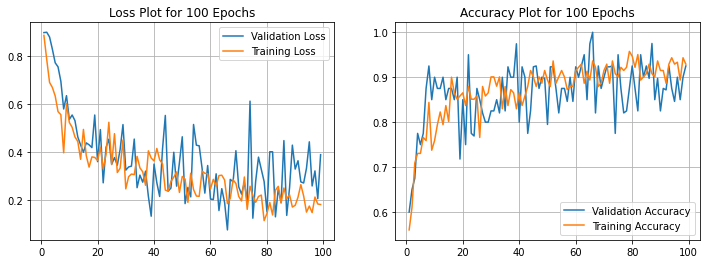

Found 27 images belonging to 3 classes.
3/3 [==============================] - 1s 311ms/step - loss: 0.0015 - acc: 1.0000
Testing Accuracy: 1.0 Testing Loss: 0.0014746878296136856
Instructions for updating:
Please use Model.predict, which supports generators.
Image Name: covid/nejmoa2001191_f3-PA.jpeg


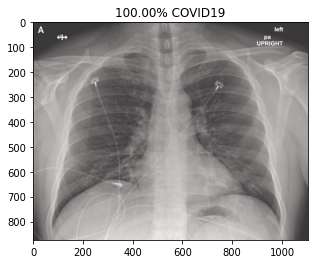

Image Name: covid/nejmoa2001191_f4.jpeg


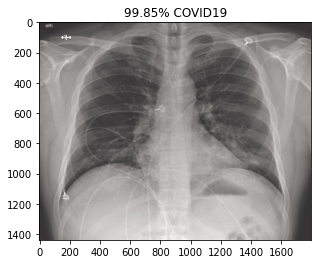

Image Name: covid/nejmoa2001191_f5-PA.jpeg


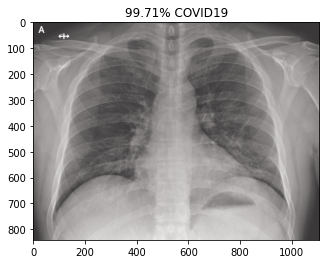

Image Name: covid/radiol.2020200490.fig3.jpeg


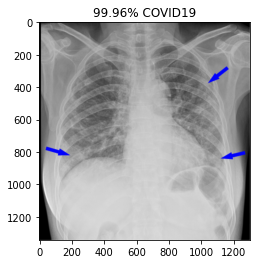

Image Name: covid/ryct.2020200028.fig1a.jpeg


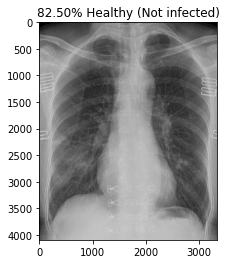

Image Name: covid/ryct.2020200034.fig2.jpeg


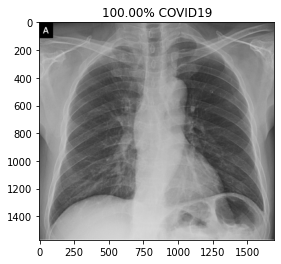

Image Name: covid/ryct.2020200034.fig5-day0.jpeg


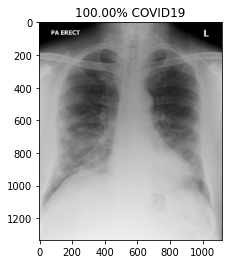

Image Name: covid/ryct.2020200034.fig5-day4.jpeg


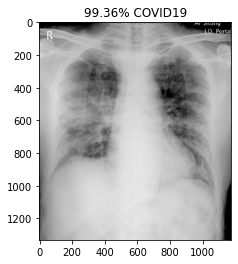

Image Name: covid/ryct.2020200034.fig5-day7.jpeg


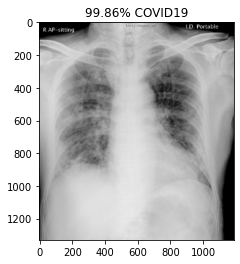

Image Name: normal/NORMAL2-IM-1385-0001.jpeg


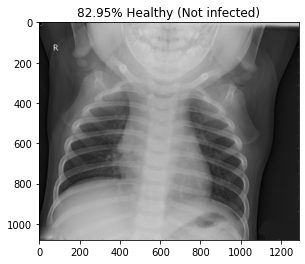

Image Name: normal/NORMAL2-IM-1396-0001.jpeg


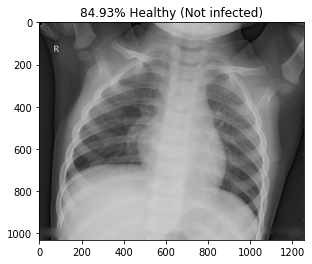

Image Name: normal/NORMAL2-IM-1400-0001.jpeg


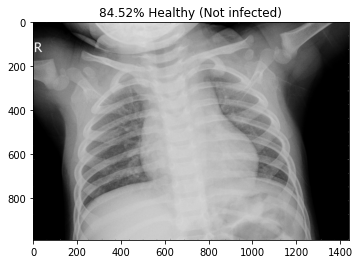

Image Name: normal/NORMAL2-IM-1401-0001.jpeg


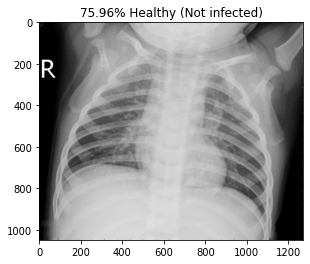

Image Name: normal/NORMAL2-IM-1406-0001.jpeg


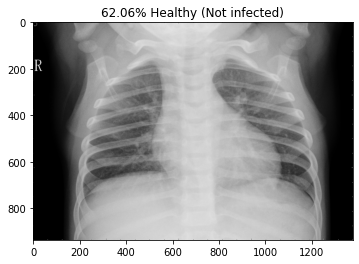

Image Name: normal/NORMAL2-IM-1412-0001.jpeg


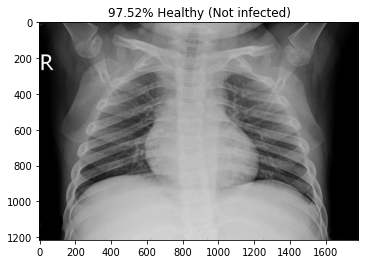

Image Name: normal/NORMAL2-IM-1419-0001.jpeg


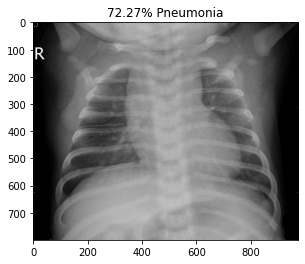

Image Name: normal/NORMAL2-IM-1422-0001.jpeg


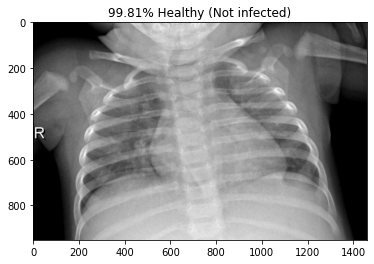

Image Name: normal/NORMAL2-IM-1423-0001.jpeg


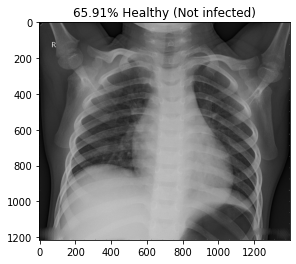

Image Name: pneumonia_bac_test/person1753_bacteria_4594.jpeg


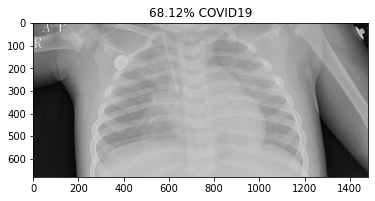

Image Name: pneumonia_bac_test/person1940_bacteria_4859.jpeg


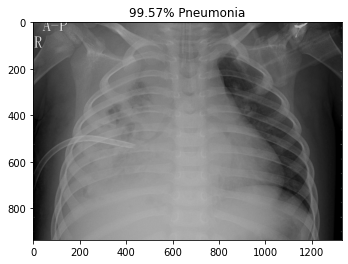

Image Name: pneumonia_bac_test/person1940_bacteria_4861.jpeg


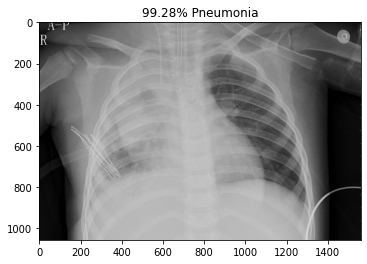

Image Name: pneumonia_bac_test/person1940_bacteria_4862.jpeg


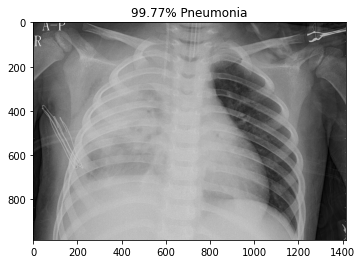

Image Name: pneumonia_bac_test/person1941_bacteria_4863.jpeg


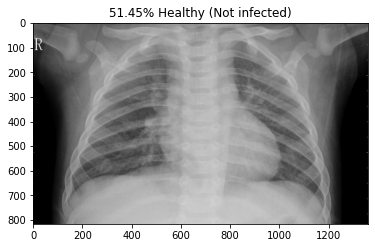

Image Name: pneumonia_bac_test/person1942_bacteria_4865.jpeg


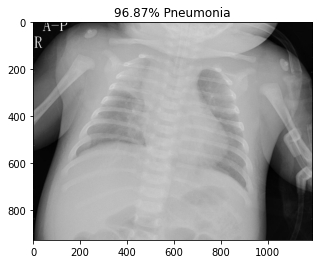

Image Name: pneumonia_bac_test/person1943_bacteria_4868.jpeg


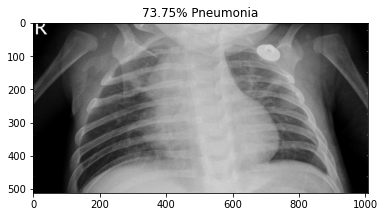

Image Name: pneumonia_bac_test/person1944_bacteria_4869.jpeg


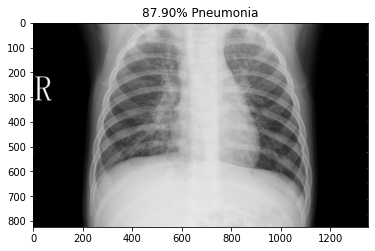

Image Name: pneumonia_bac_test/person1945_bacteria_4872.jpeg


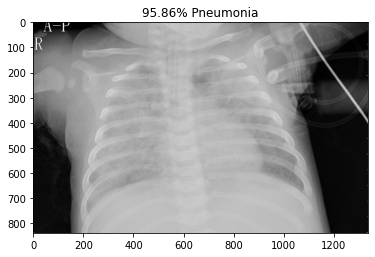

In [ ]:
def main():
    valid_data_batch = data_augmentation(False) #Generating Validation data
    train_data_batch = data_augmentation() #Generating training data
    value = model_save_degrade() #Function for saving checkpoints
    model = build_model() #Building the custom model
    trained_model = train_model(model, train_data_batch, valid_data_batch, value, num_epochs) #Training the custom model
    train_val_graphs(trained_model, epochs = num_epochs) #Plotting the trained model metrics
    testing_model(model) #Testing the custom model on test data

if __name__ == '__main__':
    main()